# Import Packages & Check Requirements

In [67]:
# Import Prophet
from prophet import Prophet

# Import Cryptocurrency library to extract BTC price
import ccxt

# Import essentials of Data Science & Analytics
import pandas as pd
import numpy as np
import matplotlib as plt
from datetime import datetime

In [68]:
# Check the version of libraries and make sure they are aligned with the requirements

print('ccxt: {}'.format(ccxt.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Matplotlib: {}'.format(plt.__version__))
print('Prophet: {}'.format(prophet.__version__))

ccxt: 1.39.42
Pandas: 1.3.5
Numpy: 1.21.6
Matplotlib: 3.1.1
Prophet: 1.0


# Load & Clean Data

In [69]:
def load_and_clean(exchange = ccxt.binance, since = '2022-08-01T00:00:00Z', symbol = 'BTC/USDT', timeframe = '1d'):
    'Load price data from any exchange of any cryptocurrency starting from any date & time with desired timeframe. Check the exchange fetch function before running' 
    
    # Start with instantiation
    exchange_inst = exchange()
    
    # Force HTTP reload = True. If not reloaded, then it shows cached version
    reloadedMarkets = exchange_inst.load_markets(True)
   
    # Fetch prices
    crypto_price_data = []
    position = symbol.find('/')
    crypto = symbol[:position]
    since_parsed = exchange_inst.parse8601(since)
    
    while since_parsed < exchange_inst.milliseconds():
        price_batch = exchange_inst.fetchOHLCV(symbol, timeframe, since_parsed, params = {})
        if price_batch:
            crypto_price_data += price_batch
            since_parsed = max(price_batch)[0] + 1
        else:
            break
            
    crypto_price_data = pd.DataFrame(crypto_price_data)  
    crypto_price_data['SYMBOL'] = crypto
    
    def clean_data(crypto_price_data):
        'Converts timestamp to human-readable format and modifies columns'
    
        # Convert timestamp to human-readable format
        for i in range(len(crypto_price_data)):
            timestamp_temp = int(crypto_price_data.iloc[i:i+1][0])
            timestamp = timestamp_temp/1000
            date = datetime.fromtimestamp(timestamp)
            crypto_price_data.at[i, 0] = date
            i += 1
    
        # Modify columns
        crypto_price_data['TIME'] = crypto_price_data[0]
        crypto_price_data['OPEN'] = crypto_price_data[1]
        crypto_price_data['HIGH'] = crypto_price_data[2]
        crypto_price_data['LOW'] = crypto_price_data[3]
        crypto_price_data['CLOSE'] = crypto_price_data[4]
        crypto_price_data['VOLUME'] = crypto_price_data[5]
    
        # Drop the old columns
        crypto_price_data.drop(columns = [0, 1, 2, 3, 4, 5], axis = 1, inplace = True)
    
        return crypto_price_data
    
    return clean_data(crypto_price_data)


In [70]:
# Check whether the data is loaded and cleaned as intented
data = load_and_clean(exchange = ccxt.binance, since = '2022-08-01T00:00:00Z', symbol = 'BTC/USDT', timeframe = '1d')

data.tail()

,SYMBOL,TIME,OPEN,HIGH,LOW,CLOSE,VOLUME
31,BTC,2022-09-01 02:00:00,20048.44,20208.37,19565.66,20131.46,245289.97263
32,BTC,2022-09-02 02:00:00,20132.64,20441.26,19755.29,19951.86,245986.60330
33,BTC,2022-09-03 02:00:00,19950.98,20055.93,19652.72,19831.90,146639.03204
34,BTC,2022-09-04 02:00:00,19832.45,20029.23,19583.10,20000.30,145588.77893
35,BTC,2022-09-05 02:00:00,20000.30,20057.27,19681.22,19755.62,73297.12847


# Prepare Data for Prophet

In [71]:
# Prophet allows only 2 columns to be fed in with specific names: Time with name 'ds' and value with name 'y'

data_prophet = data.drop(columns = ['SYMBOL', 'OPEN', 'HIGH', 'LOW', 'VOLUME'], axis = 1)

data_prophet.columns = ['ds', 'y']

data_prophet.tail()

,ds,y
31,2022-09-01 02:00:00,20131.46
32,2022-09-02 02:00:00,19951.86
33,2022-09-03 02:00:00,19831.90
34,2022-09-04 02:00:00,20000.30
35,2022-09-05 02:00:00,19755.62


# Fit Prophet & Make Prediction

In [72]:
# Define the time horizon to predict (Next 7-days BTC price)
predict_horizon = 7

# Fit BTC price into Prophet
prophet_model = Prophet()
prophet_model.fit(data_prophet)

# Make Prediction
future_prophet = prophet_model.make_future_dataframe(periods = predict_horizon)
forecast_prophet = prophet_model.predict(future_prophet)

# Show Predictions (In Prophet's output, yhat is the prediction)
forecast_prophet_final = forecast_prophet[['ds', 'yhat']]
forecast_prophet_final.columns = ['TIME', 'PREDICTION']
forecast_prophet_final.tail(predict_horizon)

09:55:49 - cmdstanpy - INFO - Chain [1] start processing
09:55:49 - cmdstanpy - INFO - Chain [1] done processing


,TIME,PREDICTION
36,2022-09-06 02:00:00,19429.492737
37,2022-09-07 02:00:00,19472.732693
38,2022-09-08 02:00:00,19457.161457
39,2022-09-09 02:00:00,18921.281005
40,2022-09-10 02:00:00,18856.894599
41,2022-09-11 02:00:00,18855.673430
42,2022-09-12 02:00:00,19072.441525


# Visualize Prediction

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



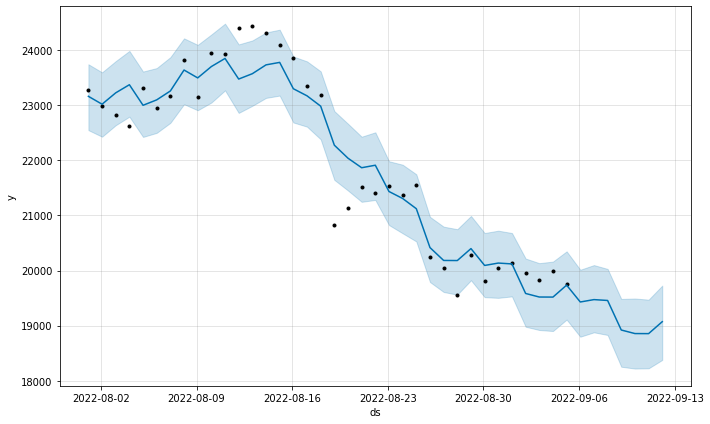

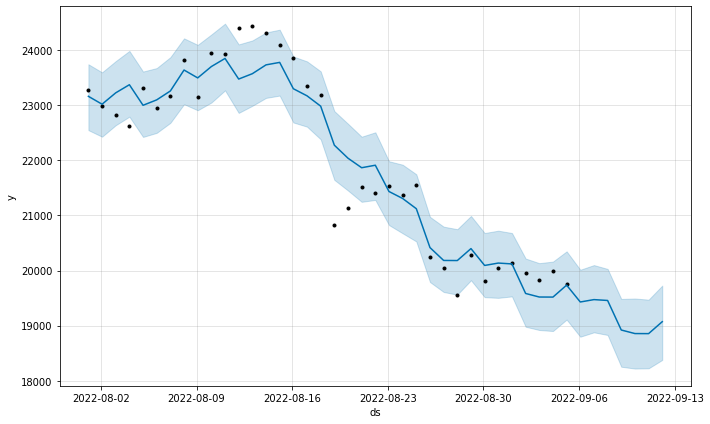

In [73]:
prophet_model.plot(forecast_prophet)

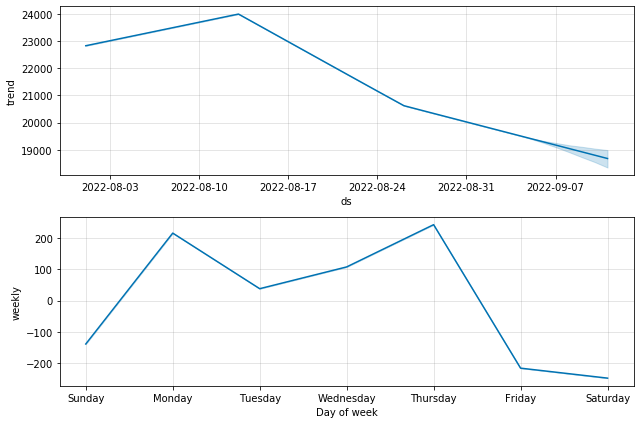

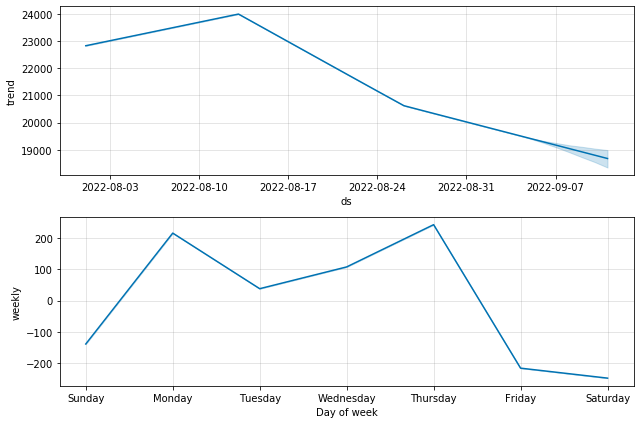

In [66]:
prophet_model.plot_components(forecast_prophet)